
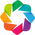

In [82]:
import bokeh
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
from bokeh.io import show
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
from bokeh.palettes import YlOrRd as palette  #Spectral6 as palette
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
from bokeh.palettes import RdYlGn10 as palette 
import holoviews as hv
hv.extension('bokeh')

In [83]:
city_geo_price = gpd.read_file('data/city_geo_price.shp')

In [84]:
city_geo_price['PRICE IN K'] = city_geo_price['PRICE IN K'].astype(int)
city_geo_price['$/SQUARE F'] = city_geo_price['$/SQUARE F'].astype(int)

In [85]:
def getXYCoords(geometry, coord_type):
    """ Returns either x or y coordinates from  geometry coordinate sequence. Used with LineString and Polygon geometries."""
    if coord_type == 'x':
        return geometry.coords.xy[0]
    elif coord_type == 'y':
        return geometry.coords.xy[1]

def getPolyCoords(geometry, coord_type):
    """ Returns Coordinates of Polygon using the Exterior of the Polygon."""
    ext = geometry.exterior
    return getXYCoords(ext, coord_type)
    
def getLineCoords(geometry, coord_type):
    """ Returns Coordinates of Linestring object."""
    return getXYCoords(geometry, coord_type)

def getPointCoords(geometry, coord_type):
    """ Returns Coordinates of Point object."""
    if coord_type == 'x':
        return geometry.x
    elif coord_type == 'y':
        return geometry.y
    
def multiGeomHandler(multi_geometry, coord_type, geom_type):
    """ 
    Function for handling multi-geometries. Can be MultiPoint, MultiLineString or MultiPolygon. 
    Returns a list of coordinates where all parts of Multi-geometries are merged into a single list. 
    Individual geometries are separated with np.nan which is how Bokeh wants them. 
    # Bokeh documentation regarding the Multi-geometry issues can be found here (it is an open issue)
    # https://github.com/bokeh/bokeh/issues/2321
    """
    
    for i, part in enumerate(multi_geometry):
        # On the first part of the Multi-geometry initialize the coord_array (np.array)
        if i == 0:
            if geom_type == "MultiPoint":
                coord_arrays = np.append(getPointCoords(part, coord_type), np.nan)
            elif geom_type == "MultiLineString":
                coord_arrays = np.append(getLineCoords(part, coord_type), np.nan)
            elif geom_type == "MultiPolygon":
                coord_arrays = np.append(getPolyCoords(part, coord_type), np.nan)
        else:
            if geom_type == "MultiPoint":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPointCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiLineString":
                coord_arrays = np.concatenate([coord_arrays, np.append(getLineCoords(part, coord_type), np.nan)])
            elif geom_type == "MultiPolygon":
                coord_arrays = np.concatenate([coord_arrays, np.append(getPolyCoords(part, coord_type), np.nan)])
    
    # Return the coordinates 
    return coord_arrays
    

def getCoords(row, geom_col, coord_type):
    """
    Returns coordinates ('x' or 'y') of a geometry (Point, LineString or Polygon) as a list (if geometry is LineString or Polygon). 
    Can handle also MultiGeometries.
    """
    # Get geometry
    geom = row[geom_col]
    
    # Check the geometry type
    gtype = geom.geom_type
    
    # "Normal" geometries
    # -------------------
    
    if gtype == "Point":
        return getPointCoords(geom, coord_type)
    elif gtype == "LineString":
        return list( getLineCoords(geom, coord_type) )
    elif gtype == "Polygon":
        return list( getPolyCoords(geom, coord_type) )
        
    # Multi geometries
    # ----------------
    
    else:
        return list( multiGeomHandler(geom, coord_type, gtype) ) 
       

In [86]:
city_geo_price['x'] = city_geo_price.apply(getCoords, geom_col="geometry", coord_type="x", axis=1)
city_geo_price['y'] = city_geo_price.apply(getCoords, geom_col="geometry", coord_type="y", axis=1)
city_geo_price['x'] = [np.asarray(i) for i in city_geo_price['x']]
city_geo_price['y'] = [np.asarray(i) for i in city_geo_price['y']]

In [87]:
city_geo_price

,NAME,CityType,Pop2010,Land_sqmi,DateIncorp,WebLink,County,Notes,CityAbbv,PRICE IN K,$/SQUARE F,geometry,x,y
0,GILROY,City,48821,16.15,1870-03-12,http://www.cityofgilroy.org,Santa Clara,,Gil,646,372,POLYGON ((-121.5891064263205 37.04772893374334...,"[-121.589106426, -121.585942105, -121.58292954...","[37.0477289337, 37.0414317018, 37.0355671742, ..."
1,MORGAN HILL,City,37882,12.88,1906-11-10,http://www.morgan-hill.ca.gov,Santa Clara,,MgH,756,436,POLYGON ((-121.6429347991943 37.16795921325684...,"[-121.642934799, -121.642580032, -121.64220237...","[37.1679592133, 37.1678447723, 37.1686115265, ..."
2,MONTE SERENO,City,3341,1.62,1957-05-14,http://www.montesereno.org,Santa Clara,,MSo,2906,906,POLYGON ((-121.9772510528564 37.25112342834473...,"[-121.977251053, -121.976697922, -121.97428703...","[37.2511234283, 37.2493228912, 37.2491283417, ..."
3,LOS GATOS,Town,29413,11.08,1887-08-10,http://www.losgatosca.gov,Santa Clara,43-15-008,LGts,1495,790,"POLYGON ((-121.9539885568182 37.2122263955635,...","[-121.953988557, -121.953143601, -121.95312262...","[37.2122263956, 37.2122302103, 37.2116389322, ..."
4,SARATOGA,City,29926,12.38,1956-10-22,http://www.saratoga.ca.us,Santa Clara,,Sar,2050,954,POLYGON ((-122.0027252414766 37.29376939544144...,"[-122.002725241, -122.003169972, -121.99389997...","[37.2937693954, 37.2930699684, 37.2919799685, ..."
5,CAMPBELL,City,39349,5.80,1952-03-28,http://www.cityofcampbell.com,Santa Clara,,Cmb,1046,733,"POLYGON ((-121.9391632080078 37.2730884552002,...","[-121.939163208, -121.939188004, -121.93918418...","[37.2730884552, 37.2730884552, 37.2729969025, ..."
6,CUPERTINO,City,58302,11.26,1955-10-10,http://www.cupertino.org,Santa Clara,,Cpo,1521,1035,POLYGON ((-122.0436935424805 37.33400917053223...,"[-122.043693542, -122.043693542, -122.04151153...","[37.3340091705, 37.3339252472, 37.3338718414, ..."
7,LOS ALTOS HILLS,Town,7922,8.80,1956-01-27,http://www.losaltoshills.ca.gov,Santa Clara,,LAH,4114,12930,POLYGON ((-122.1636123657227 37.38809776306152...,"[-122.163612366, -122.163284302, -122.16263961...","[37.3880977631, 37.3880748749, 37.3883152008, ..."
8,SAN JOSE,City,945942,176.53,1850-03-27,http://www.sanjoseca.gov,Santa Clara,,SJs,748,635,"POLYGON ((-121.75232046162 37.40037535543836, ...","[-121.752320462, -121.751064506, -121.75078613...","[37.4003753554, 37.4003487706, 37.4004317142, ..."
9,LOS ALTOS,City,28976,6.49,1952-12-01,http://www.ci.los-altos.ca.us,Santa Clara,,LAts,2589,5222,"POLYGON ((-122.1189498901367 37.4055347442627,...","[-122.11894989, -122.117557526, -122.115789413...","[37.4055347443, 37.4043331146, 37.4028224945, ..."


In [88]:
palette.reverse()

color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    xs=city_geo_price['x'],
    ys=city_geo_price['y'],
    name=city_geo_price['NAME'],
    price=city_geo_price['PRICE IN K'],
    unit_price = city_geo_price['$/SQUARE F']
))


TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Bay Area House Price Choropleth Map", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.grid.grid_line_color = None

p.patches(xs="xs", ys="ys", source=source,
          fill_color={'field': 'price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("PRICE IN K", "@price"),
    ("Dollar per sqft", "@unit_price")
]

show(p)

ERROR:/Users/yishi/.ipython/bokeh/core/validation/check.py:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: objectid, xs, ys [renderer: GlyphRenderer(id='4cc4b1bc-8eec-4b06-acb6-26f19d9b5689', ...)]
ERROR:/Users/yishi/.ipython/bokeh/core/validation/check.py:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: rate [renderer: GlyphRenderer(id='f2f675b7-f446-4766-9798-b999a251543e', ...)]


ValueError: Out of range float values are not JSON compliant